## Conditional GAN
Reference: 
https://www.kaggle.com/arturlacerda/pytorch-conditional-gan?select=fashion-mnist_train.csv
https://www.kaggle.com/zalando-research/fashionmnist


In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('./fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [4]:
dataset = FashionMNIST()
dataset[0][0]

In [21]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()
        
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [23]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [24]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [28]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

In [29]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

Starting epoch 0...
g_loss: 3.2807650566101074, d_loss: 0.26118457317352295


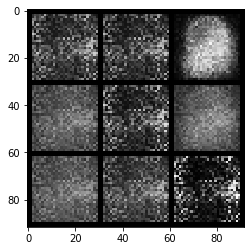

Starting epoch 1...
g_loss: 5.816344261169434, d_loss: 0.27445924282073975


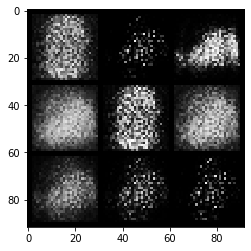

Starting epoch 2...
g_loss: 4.004941940307617, d_loss: 0.3246266841888428


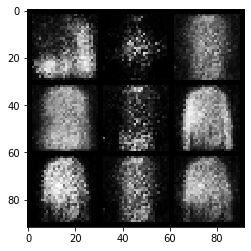

Starting epoch 3...
g_loss: 2.943297863006592, d_loss: 0.5869350433349609


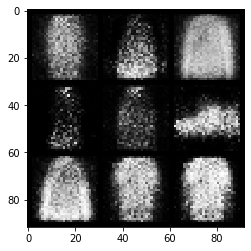

Starting epoch 4...
g_loss: 3.208051919937134, d_loss: 0.31302934885025024


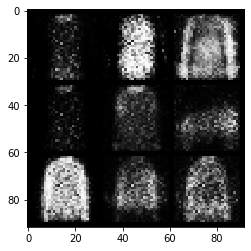

Starting epoch 5...
g_loss: 2.4181814193725586, d_loss: 0.4313490390777588


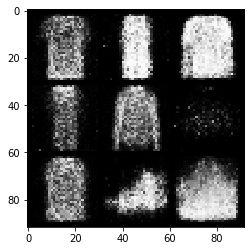

Starting epoch 6...
g_loss: 2.596832036972046, d_loss: 0.9316273927688599


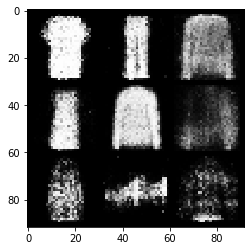

Starting epoch 7...
g_loss: 1.8795726299285889, d_loss: 0.6547021865844727


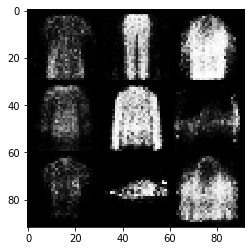

Starting epoch 8...
g_loss: 1.8554461002349854, d_loss: 0.784632682800293


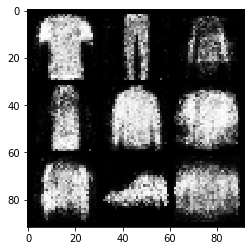

Starting epoch 9...
g_loss: 1.705075979232788, d_loss: 0.8367294073104858


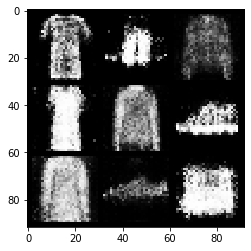

Starting epoch 10...
g_loss: 1.8634917736053467, d_loss: 0.6657123565673828


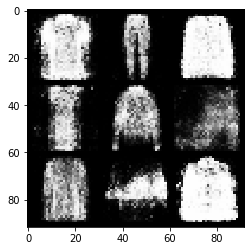

Starting epoch 11...
g_loss: 2.088531017303467, d_loss: 1.1580077409744263


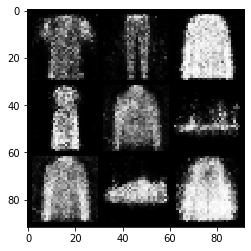

Starting epoch 12...
g_loss: 2.114407539367676, d_loss: 0.9393614530563354


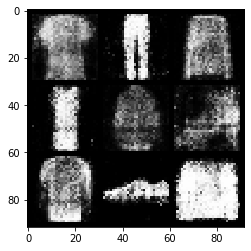

Starting epoch 13...
g_loss: 2.024264335632324, d_loss: 0.9328392148017883


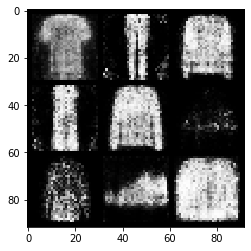

Starting epoch 14...
g_loss: 1.8929399251937866, d_loss: 0.8709302544593811


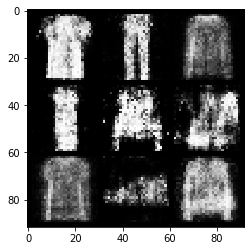

Starting epoch 15...
g_loss: 1.2530204057693481, d_loss: 1.2149090766906738


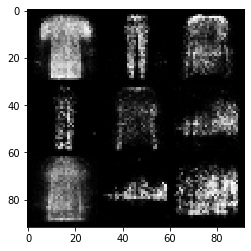

Starting epoch 16...
g_loss: 1.519317388534546, d_loss: 0.6349304914474487


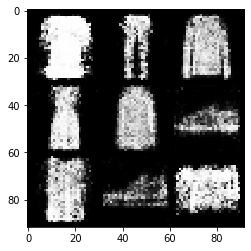

Starting epoch 17...
g_loss: 1.5815469026565552, d_loss: 0.8421122431755066


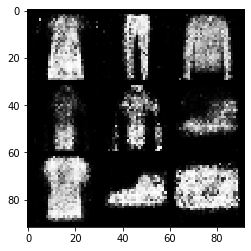

Starting epoch 18...
g_loss: 1.450554609298706, d_loss: 1.0322914123535156


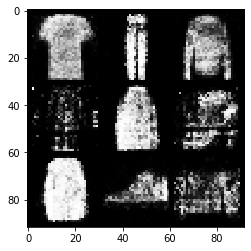

Starting epoch 19...
g_loss: 1.506339430809021, d_loss: 1.1389598846435547


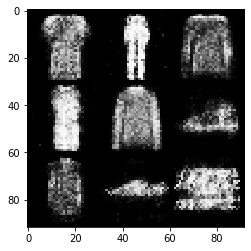

Starting epoch 20...
g_loss: 1.48480224609375, d_loss: 0.9436733722686768


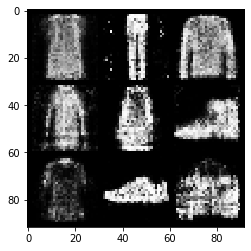

Starting epoch 21...
g_loss: 1.066185712814331, d_loss: 1.0946059226989746


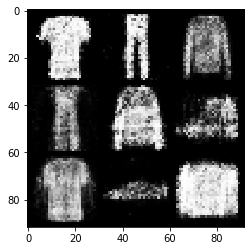

Starting epoch 22...
g_loss: 1.5435850620269775, d_loss: 1.0794436931610107


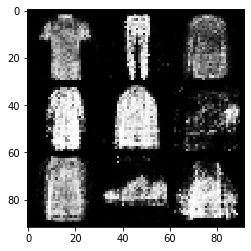

Starting epoch 23...
g_loss: 1.384462594985962, d_loss: 1.192673921585083


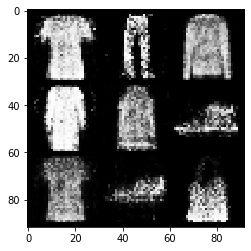

Starting epoch 24...
g_loss: 1.1803330183029175, d_loss: 1.1946483850479126


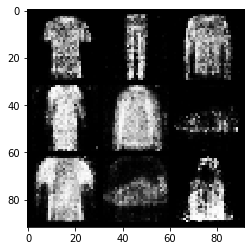

Starting epoch 25...
g_loss: 1.4038605690002441, d_loss: 0.7646844387054443


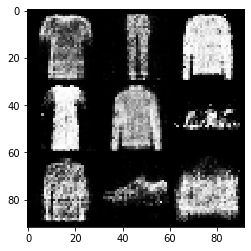

Starting epoch 26...
g_loss: 1.255584955215454, d_loss: 0.87788987159729


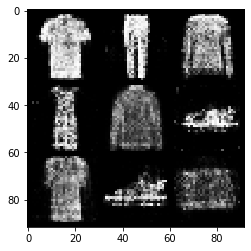

Starting epoch 27...
g_loss: 1.3152742385864258, d_loss: 1.1903387308120728


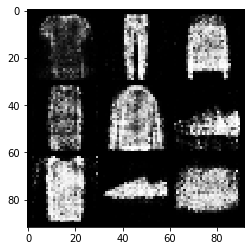

Starting epoch 28...
g_loss: 0.8779149055480957, d_loss: 0.88667893409729


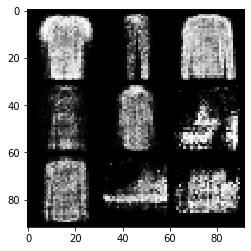

Starting epoch 29...
g_loss: 1.0856446027755737, d_loss: 1.094583511352539


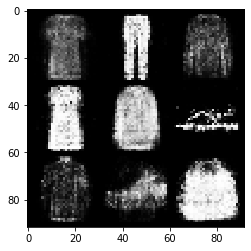

In [30]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

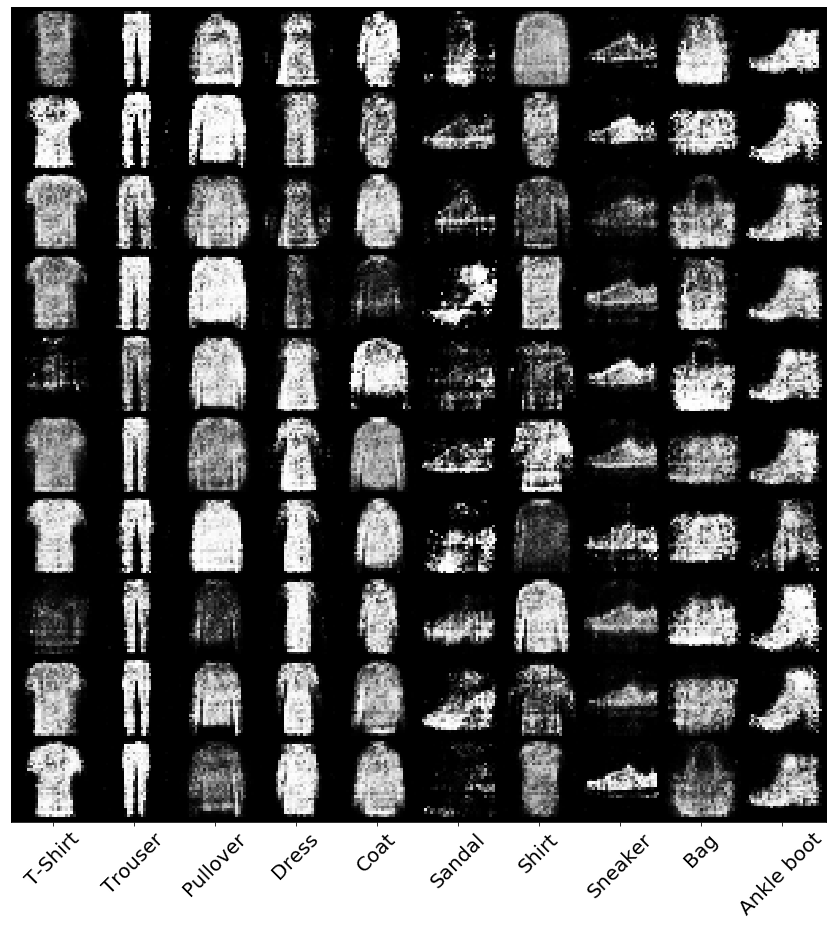

In [31]:
z = Variable(torch.randn(100, 100)).cuda()
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).cuda()
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], rotation=45, fontsize=20)